In [37]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import functional as F

In [96]:
import xarray as xr
import iris
import numpy as np

iris.FUTURE.netcdf_promote = True

import os
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from scipy.misc import toimage

def list_mogreps_uk(folder, years, months, days, hours, fcsts):
    fs = ['prods_op_mogreps-uk_{:04d}{:02d}{:02d}_{:02d}_00_{:03d}.nc'.format(year, month, day, hour, fcst)
            for year in years for month in months for day in days for hour in hours for fcst in fcsts]
    fs = [os.path.join(folder,f) for f in fs]
    return fs

class PrecipDataset(Dataset):
    def __init__(self, array, transform=None):
        self.array = array
        self.transform = transform

    def __len__(self):
        return len(self.array)

    def __getitem__(self, idx):
        def low_res(self, array, scale_factor, r=1):
            low_res = np.add.reduceat(np.add.reduceat(array.data, 
                                                      list(range(0, array.data.shape[0], scale_factor))),
                                      list(range(0, array.data.shape[1], scale_factor)), 
                                      axis=1) / scale_factor ** 2
            low_res = low_res.repeat(r, 0).repeat(r, 1)
            
            img = toimage(low_res.data)
            if self.transform:
                img = self.transform(img)
            return img
            
        try:
            precip = self.array[idx, :544, :416]

#             scale_factor = 4
#             low_res = np.add.reduceat(np.add.reduceat(precip.data, 
#                                                       list(range(0, precip.data.shape[0], scale_factor))),
#                                       list(range(0, precip.data.shape[1], scale_factor)), 
#                                       axis=1) / scale_factor ** 2

#             img = toimage(low_res.data)

#             if self.transform:
#                 img = self.transform(img)

            return low_res(self, precip, 16, 4), \
                   low_res(self, precip, 4)
        except:
            return self.__getitem__(np.random.randint(0, len(self.array)))

In [6]:
arrays = np.load('data/cloud_data.npz')

input_data = arrays['data']
test_data = arrays['test']

precip = PrecipDataset(input_data)

In [7]:
from torchvision import datasets, transforms
precip_train = PrecipDataset(input_data,
                             transform=transforms.ToTensor())

precip_test = PrecipDataset(test_data,
                            transform=transforms.ToTensor())

In [12]:
args_dict = {'batch_size': 5,
             'epochs': 100,
             'cuda': True,
             'seed': 1,
             'log_interval': 10}
args = type('test', (object,), {})()
args.__dict__.update(args_dict)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(precip_train,
                                           batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(precip_test,
                                          batch_size=args.batch_size, shuffle=True, **kwargs)

In [107]:
# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [245]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1),
            nn.ReLU())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
#         out = out.view(out.size(0), -1)
#         print(out.shape)
#         out = self.fc(out)
        return out
        
cnn = CNN()

def loss_function(recon_x, x):
    BCE = F.l1_loss(recon_x, x)
    
#     KL = F.kl_div(recon_x, x.log())
    
#     KLs = []
#     n = 16
#     d = recon_x.data.numpy()
#     for i in range(d.shape[2] // n):
#         for j in range(d.shape[3] // n):
#             KL_ = np.max(np.abs((np.max(d[:, :, i*n:i*n+n, j*n:j*n+n], axis=(2,3)) - \
#                                  np.min(d[:, :, i*n:i*n+n, j*n:j*n+n], axis=(2,3))) - \
#                                ((np.max(x.data.numpy()[:, :, i*n:i*n+n, j*n:j*n+n], axis=(2,3)) - \
#                                  np.min(x.data.numpy()[:, :, i*n:i*n+n, j*n:j*n+n], axis=(2,3))))))
#             KLs.append(KL_)

#     loss = BCE
#     for kl in KLs:
#         loss += Variable(torch.from_numpy(np.array([kl])))
    
    return BCE


# Loss and Optimizer
criterion = nn.KLDivLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(precip_test)//batch_size, loss.data[0]))

# Test the Model
cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    outputs = cnn(images)
#     _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (np.all(outputs.data.numpy() - labels.numpy() < 0.1, axis=(-2,-1))).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

Epoch [1/5], Iter [100/1] Loss: 0.3009
Epoch [2/5], Iter [100/1] Loss: 0.2366
Epoch [3/5], Iter [100/1] Loss: 0.1642
Epoch [4/5], Iter [100/1] Loss: 0.0784
Epoch [5/5], Iter [100/1] Loss: 0.0960
Test Accuracy of the model on the 10000 test images: 0 %


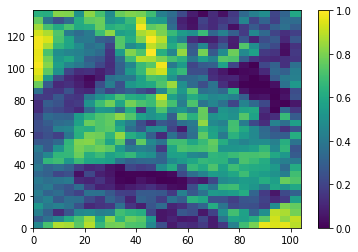

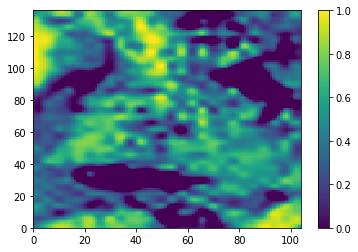

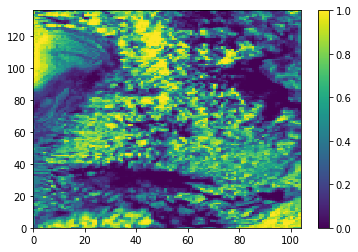

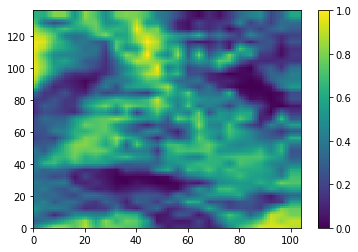

In [247]:
from matplotlib import pyplot as plt
%matplotlib inline
n = 2
plt.pcolormesh(images[n,0,:,:].data.numpy()); plt.colorbar(); plt.show()
plt.pcolormesh(outputs[n,0,:,:].data.numpy(), vmax=1); plt.colorbar(); plt.show()
plt.pcolormesh(labels[n,0,:,:].numpy()); plt.colorbar(); plt.show()

t = images[n,0,::4,::4]
plt.pcolormesh(sp.interpolate.interp2d(np.arange(0,t.shape[1]*4,4), 
                                       np.arange(0,t.shape[0]*4,4), t)(
    np.arange(images[n,0,:,:].shape[1]), np.arange(images[n,0,:,:].shape[0]))); plt.colorbar(); plt.show()

In [156]:
labels.shape

torch.Size([5, 1, 136, 104])

In [31]:
504 / 4

126.0

In [30]:
548 / 4

137.0